In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import os

# I get an error without this...
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(19, 19, 23)))
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [3]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 17, 17, 32)        6656      
_________________________________________________________________
dropout (Dropout)            (None, 17, 17, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 64)          3

In [5]:
import pickle
structures = pickle.load(open("processed_data/structure_density_maps.pickle", "rb"))
structures_names = pickle.load(open("processed_data/structure_density_maps_names.pickle", "rb"))
structures_labels = pickle.load(open("processed_data/structure_density_maps_labels.pickle", "rb"))

import sklearn.model_selection

(
    train_X,
    test_X,
    train_Y,
    test_Y,
    train_names,
    test_names
) = sklearn.model_selection.train_test_split(structures, structures_labels, structures_names, test_size=0.2)

bool_train_labels = train_Y != 0
bool_test_labels = test_Y != 0

pos_train_examples, neg_train_examples = train_X[bool_train_labels], train_X[~bool_train_labels]
pos_test_examples, neg_test_examples = test_X[bool_test_labels], test_X[~bool_test_labels]

print("Training on", train_X.shape[0], "total examples.",
      len(pos_train_examples), "positive examples,", len(neg_train_examples), "negative examples.")
print("Testing on", test_X.shape[0], "total examples.",
      len(pos_test_examples), "positive examples,", len(neg_test_examples), "negative examples.")

Training on 4028 total examples. 853 positive examples, 3175 negative examples.
Testing on 1007 total examples. 237 positive examples, 770 negative examples.


In [6]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=20,
    min_delta=0.01,
    restore_best_weights=True,
)

model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=metrics)

history = model.fit(train_X,
                    train_Y,
                    epochs=100,
                    verbose=1,
                    callbacks=[early_stopping],
                    validation_data=(test_X, test_Y),
                    class_weight={0: 1, 1: 4}
                   )

Epoch 1/100
126/126 [==============================] - 2s 18ms/step - loss: 1.1231 - tp: 592.0000 - fp: 1796.0000 - tn: 1379.0000 - fn: 261.0000 - accuracy: 0.4893 - precision: 0.2479 - recall: 0.6940 - auc: 0.5896 - prc: 0.2735 - val_loss: 0.7288 - val_tp: 210.0000 - val_fp: 595.0000 - val_tn: 175.0000 - val_fn: 27.0000 - val_accuracy: 0.3823 - val_precision: 0.2609 - val_recall: 0.8861 - val_auc: 0.6274 - val_prc: 0.3367
Epoch 2/100
126/126 [==============================] - 1s 9ms/step - loss: 1.0943 - tp: 601.0000 - fp: 1657.0000 - tn: 1518.0000 - fn: 252.0000 - accuracy: 0.5261 - precision: 0.2662 - recall: 0.7046 - auc: 0.6297 - prc: 0.3094 - val_loss: 0.6749 - val_tp: 140.0000 - val_fp: 294.0000 - val_tn: 476.0000 - val_fn: 97.0000 - val_accuracy: 0.6117 - val_precision: 0.3226 - val_recall: 0.5907 - val_auc: 0.6457 - val_prc: 0.3395
Epoch 3/100
126/126 [==============================] - 1s 8ms/step - loss: 1.0762 - tp: 574.0000 - fp: 1497.0000 - tn: 1678.0000 - fn: 279.0000 - a

32/32 [==============================] - 0s 5ms/step - loss: 0.7288 - tp: 210.0000 - fp: 595.0000 - tn: 175.0000 - fn: 27.0000 - accuracy: 0.3823 - precision: 0.2609 - recall: 0.8861 - auc: 0.6274 - prc: 0.3367
loss : 0.7287580966949463
tp : 210.0
fp : 595.0
tn : 175.0
fn : 27.0
accuracy : 0.3823237419128418
precision : 0.260869562625885
recall : 0.8860759735107422
auc : 0.6273631453514099
prc : 0.33673152327537537



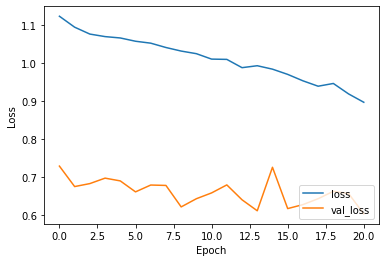

In [7]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')

pred_Y_results = model.evaluate(test_X, test_Y, verbose=1)
for name, value in zip(model.metrics_names, pred_Y_results):
    print(name, ':', value)
print()